In [1]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),

])

In [4]:
val_dataset = torchvision.datasets.DatasetFolder('Processed/val/', loader=load_file, extensions='npy',
                                                 transform=val_transforms)

In [5]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        # We're cutting the last two layers because, we want to know the reason 
        # why our model predicts an image as positive or negative
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):
        feature_map = self.feature_map(data)
        # Our feature map dimension in ResNet before fully connected layer is 7X7X512(not related to kernel size)
        # With average pooling it's now 1X1X512
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        # Flatten image for fully connected layer
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flattened)
        return pred, feature_map

In [9]:
# strict=False means that the function will not enforce an exact match between the model architecture and the checkpoint. Specifically,
#it allows you to load the weights from a checkpoint even if your current model architecture doesn't match exactly with the 
#architecture of the model when the checkpoint was saved.
model = PneumoniaModel.load_from_checkpoint('checkpoints/epoch=33-step=12750.ckpt', strict=False)
model.eval();

C:\Users\admin\Documents\GitHub\Pneumonia-Classification-PyTorch\venv\Lib\site-packages\pytorch_lightning\core\saving.py:161: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0

In [10]:
def cam(model, img):
    # To prevent PyTorch to store gradients
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    # Extracting weight parameters in fully connected layers
    weight_params = list(model.model.fc.parameters())[0]
    # detach() to avoid computing gradients for fully computed layers, we're only interested in CAMs
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

# the 1x1 feature map is used for classification in the forward pass of the model. However, the original 7x7 feature map is used in the
# CAM function to understand which regions of the image are important for making a particular classification. Both are useful but serve
# different purposes.

In [11]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224), antialias=True)[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap='gray')
    axis[1].imshow(img, cmap='gray')
    axis[1].imshow(cam, alpha=0.5, cmap='jet')
    plt.title(pred > 0.5)

In [12]:
# To use the model, first load your image from the val_dataset
img = val_dataset[-5][0].to('cuda')
activation_map, pred = cam(model, img)

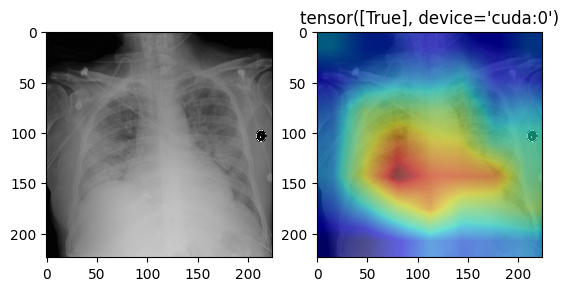

In [13]:
visualize(img.cpu().numpy(), activation_map, pred)

In [14]:
# To classify an image uncomment and modify the following code then run it

In [15]:
# import pydicom
# import cv2
# import numpy as np
# 
# # Step 1: Read the DICOM file
# dcm_path = "path/to/your/image.dcm"
# dcm = pydicom.read_file(dcm_path).pixel_array
# 
# # Step 2: Normalize and Resize
# dcm = dcm / 255
# dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float32)
# 
# # Step 3: Apply Transforms
# val_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(0.49, 0.248),
# ])
# img_tensor = val_transforms(dcm_array)
# 
# # Step 4: Move to Device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# img_tensor = img_tensor.to(device).unsqueeze(0)  # Add a batch dimension
# 
# # Step 5: Run through Model
# # Assume 'model' is your trained model
# activation_map, pred = cam(model, img_tensor)
# 
# # Do something with 'activation_map' and 'pred'
# visualize(img.cpu().numpy(), activation_map, pred)